In [ ]:
# 必要なモジュールのインポート
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.models import Model, Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.backend import set_session
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16


#モデルの保存
import os

In [ ]:
# 指定ディレクトリに存在するファイルの種類を確認
print(os.listdir("/content/drive/MyDrive/cat_dog_app/dogs-vs-cats/"))

['test1.zip', 'train.zip']


In [ ]:
# zipファイルの解凍
!unzip /content/drive/MyDrive/cat_dog_app/dogs-vs-cats/test1.zip
!unzip /content/drive/MyDrive/cat_dog_app/dogs-vs-cats/train.zip

In [ ]:
# trainフォルダ内に存在する各画像ファイルとカテゴリーのリスト化
# train用の画像にcat,dogの記述があるため、その情報を用いてdogを1、catを0として振分け
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

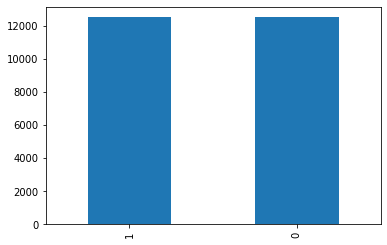

In [ ]:
df['category'].value_counts().plot.bar()

In [ ]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

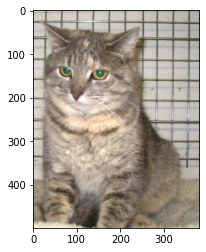

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [ ]:
# 画像サイズの指定
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3


# vgg16のインスタンスの生成
#---------------------------
input_tensor = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT,  IMAGE_CHANNELS))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
#---------------------------

top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.3))
top_model.add(Dense(2, activation='softmax'))

# モデルの連結
#---------------------------
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))
#---------------------------

# vgg16の重みの固定
#---------------------------
for layer in model.layers[:19]:
    layer.trainable = False
#---------------------------


model.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# 過学習を防ぎ、汎化性能を落とさないようにEarlyStoppingを使用
# 学習時の評価値の改善が止まった際に学習率を減らすためにReduceLROnPlateauを活用
earlystop = EarlyStopping(
    monitor = "val_accuracy",
    patience = 25,
    verbose = 1,
    mode = "max",
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000000001
)
callbacks = [earlystop, learning_rate_reduction]


# 画像データを学習用と検証用のデータに8:2の割合でランダムに振分け
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=123)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

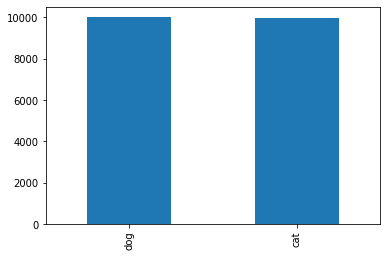

In [ ]:
train_df["category"] = train_df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df['category'].value_counts().plot.bar()

In [ ]:
train_df['category'].value_counts()

dog    10018
cat     9982
Name: category, dtype: int64

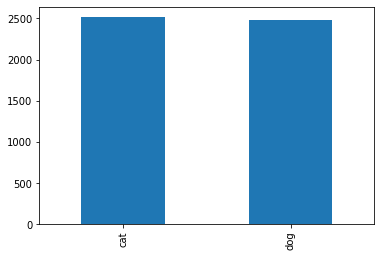

In [ ]:
validate_df["category"] = validate_df["category"].replace({0: 'cat', 1: 'dog'}) 
validate_df['category'].value_counts().plot.bar()

In [ ]:
validate_df['category'].value_counts()

cat    2518
dog    2482
Name: category, dtype: int64

In [ ]:
# バッチサイズの指定
batch_size=32

# 学習用データのAugmentationの設定
train_datagen = ImageDataGenerator(
    rotation_range=140,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
# 検証用データのAugmentationの設定
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# 確認用に1データのAugmentationの設定
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


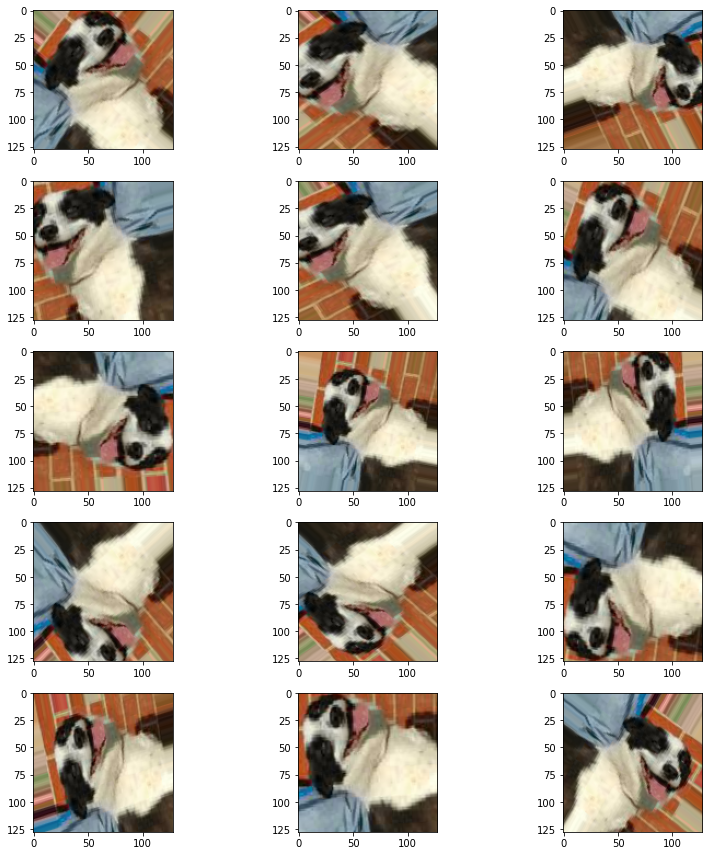

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
# 学習用、検証用データのデータ数を代入
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


# モデルの学習
epochs= 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [ ]:
# 学習結果の可視化（loss, accuracyのエポックごとの推移）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
history.history

In [ ]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df["category"]

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
label_map

In [ ]:
test_df['category'] 

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
#resultsディレクトリを作成
result_dir = 'results'
path_model  = "model.h5"
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
# 重みを保存
model.save(os.path.join(result_dir, path_model))

files.download( '/content/results/' + path_model ) 